This project will train a custom CNN model to perform image classification on CIFAR-10. Then, it will apply uncertainty quantification on the CNN model to gain insights on the confidence of its predictions.

Note: Because of the stochastic nature of many results, they may be slightly different every time they are generated. However, the nature of the results should not change.

**Mapping of CIFAR-10 Class Names to Integers (for Reference)**

airplane : 0

automobile : 1

bird : 2

cat : 3

deer : 4

dog : 5

frog : 6

horse : 7

ship : 8

truck : 9

**Import Libraries (Common Step)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from keras.layers.core import Lambda
from keras import backend as K
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from keras.optimizers import SGD
from sklearn.metrics import classification_report

**Load and Preprocess CIFAR-10 Data (Common Step)**

In [ ]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 110s 1us/step


Show a sample image.

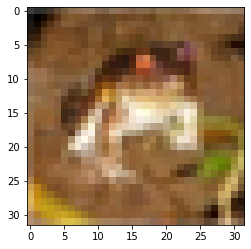

In [ ]:
plt.imshow(x_train[0])

Normalize the pixel values, which are originally in the range 0 to 255, to be within 0 and 1. 

In [ ]:
x_train = x_train/255
x_test = x_test/255

Convert the labels to be categorical labels.

In [ ]:
y_cat_test = to_categorical(y_test,10)
y_cat_train = to_categorical(y_train,10)

**CIFAR-10 Training**

In the style of VGG, which is a proven and high-performing network for image recognition and classification, this model consists of multiple blocks that each contain two convolutional layers and one max-pooling layer, with convolutional layers in each successive block containing double the number of filters as in the previous one. Meanwhile, dropout layers will not only prevent overfitting, but will help quantify uncertainty later in this project. Only 20% of units will be dropped by each dropout layer, but because there are multiple such dropout layers, overfitting is still mitigated.

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),padding='same'))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dense(10,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])

In [ ]:
#If weights are already available, use the model.load_weights line. Otherwise, to train from scratch, comment out model.load_weights and uncomment model.fit.

#If necessary, appropriately replace path to weights file.
model.load_weights('/content/drive/MyDrive/Models/CIFAR-10/cifar10.h5')

#model.fit(x_train,y_cat_train,verbose=1,epochs=20)

#If necessary, appropriately replace desired path to weights file.
#model.save_weights('/content/drive/MyDrive/Models/CIFAR-10/cifar10.h5')

The final training accuracy is impressive, but some of the high accuracy value may be a result of overfitting.

**CIFAR-10 Testing**

In [ ]:
model.evaluate(x_test,y_cat_test)

313/313 [==============================] - 50s 155ms/step - loss: 0.7199 - accuracy: 0.7863


[0.7199295163154602, 0.786300003528595]

~78% testing accuracy is decent for a relatively simple model.

In [ ]:
predictions = model.predict(x_test)
predictions = predictions.argmax(axis=-1)

313/313 [==============================] - 50s 159ms/step


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1000
           1       0.89      0.88      0.88      1000
           2       0.78      0.67      0.72      1000
           3       0.65      0.56      0.60      1000
           4       0.76      0.73      0.74      1000
           5       0.64      0.71      0.68      1000
           6       0.78      0.89      0.83      1000
           7       0.79      0.87      0.83      1000
           8       0.88      0.88      0.88      1000
           9       0.84      0.87      0.85      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.78     10000
weighted avg       0.79      0.79      0.78     10000



Classes 3 and 5, which, respectively, are cat and dog, are clearly detected more poorly than the other classes. Classes 1 and 8, which, respectively, are automobile and ship, are the classes that are detected the best.

**Uncertainty Quantification**

For this project, uncertainty will be quantified using the dropout layers. Dropout will be enabled during prediction, multiple predictions will be made, and the mean and variance of those predictions will be calculated to provide quantitative insight into the model's uncertainty.

This method is highlighted as Monte-Carlo Dropout in this article: https://medium.com/uncertainty-quantification-for-neural-networks/uncertainty-quantification-for-neural-networks-a2c5f3c1836d

It is also described here: https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html

Replace the Dropout nodes with PermaDropout nodes so that dropout is enabled during testing. Weights will otherwise remain unchanged.

PermaDropout code thanks to https://stackoverflow.com/questions/47787011/how-to-disable-dropout-while-prediction-in-keras

In [ ]:
def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),padding='same'))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(PermaDropout(0.2))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(PermaDropout(0.2))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(PermaDropout(0.2))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(PermaDropout(0.2))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same'))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(PermaDropout(0.2))
model.add(Dense(128))
model.add(Dense(10,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])

In [ ]:
model.load_weights('/content/drive/MyDrive/Models/CIFAR-10/cifar10.h5')

Make ten sets of predictions with dropout enabled. Each prediction thus carries some uncertainty.

In [ ]:
num_repetitions = 10
predictions_with_dropout = [None] * num_repetitions

for i in range(0, num_repetitions):
  predictions_with_dropout[i] = model.predict(x_test)

313/313 [==============================] - 2s 6ms/step


Obtain the mean probabilities and variance of the probabilities over the ten sets of predictions. Then, make the class predictions based on the mean probabilities. The index of the greatest mean probability within each mean prediction will be designated as the predicted class, and the greatest mean probability will be called the mean predictive probability. Finally, identify the variance that corresponds to the mean predictive probability.

In [ ]:
predictive_mean = np.mean(predictions_with_dropout, axis=0)
predictive_variance = np.var(predictions_with_dropout, axis=0)

max_probs = np.max(predictive_mean, axis=1)
sorted_max_probs = np.sort(np.max(predictive_mean, axis=1))
sorted_max_probs_args = np.argsort(np.max(predictive_mean, axis=1))

predictive_mean = [predictive_mean[i] for i in sorted_max_probs_args]
predictive_variance = [predictive_variance[i] for i in sorted_max_probs_args]

class_predictions = np.argmax(predictive_mean, axis=1)

corresponding_max_vars = [None] * len(predictive_variance)

for i in range(0, len(predictive_variance)):
  corresponding_max_vars[i] = predictive_variance[i][class_predictions[i]]

In [ ]:
def color_map(label):
  if label == 0:
    return 'red'
  if label == 1:
    return 'pink'
  if label == 2:
    return 'orange'
  if label == 3:
    return 'brown'
  if label == 4:
    return 'yellow'
  if label == 5:
    return 'green'
  if label == 6:
    return 'blue'
  if label == 7:
    return 'violet'
  if label == 8:
    return 'gray'
  if label == 9:
    return 'black'

colors = list(map(color_map, class_predictions))

In [ ]:
legend_elements = [Line2D([0], [0], marker='o', color='red', label='Airplane',
                          markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='pink', label='Automobile',
                          markerfacecolor='pink', markersize=10),
                   Line2D([0], [0], marker='o', color='orange', label='Bird',
                          markerfacecolor='orange', markersize=10),
                   Line2D([0], [0], marker='o', color='brown', label='Cat',
                          markerfacecolor='brown', markersize=10),
                   Line2D([0], [0], marker='o', color='yellow', label='Deer',
                          markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='green', label='Dog',
                          markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='blue', label='Frog',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='violet', label='Horse',
                          markerfacecolor='violet', markersize=10),
                   Line2D([0], [0], marker='o', color='gray', label='Ship',
                          markerfacecolor='gray', markersize=10),
                   Line2D([0], [0], marker='o', color='black', label='Truck',
                          markerfacecolor='black', markersize=10)]

Plot the mean predictive probability as a function of the sample index. Because the indices are ordered such that their respective mean predictive probabilities are in ascending order, there will be an increasing curve. This plot may help in observing which predicted classes tend to have higher - and lower - mean predictive probabilities.

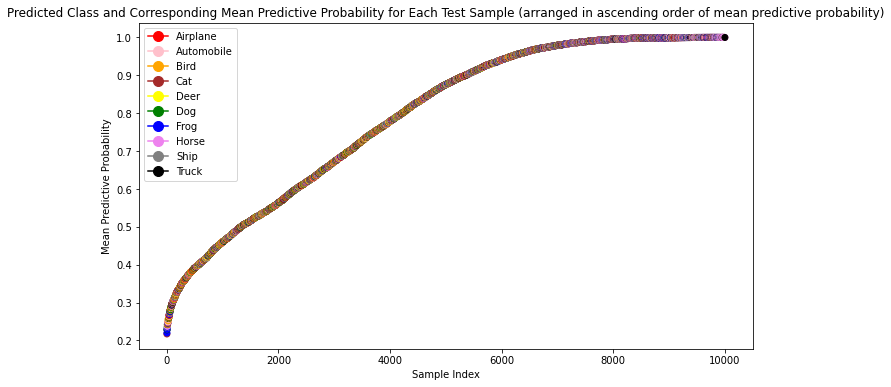

In [ ]:
plt.figure(figsize=(11,6))
plt.xlabel('Sample Index')
plt.ylabel('Mean Predictive Probability')
plt.title('Predicted Class and Corresponding Mean Predictive Probability for Each Test Sample (arranged in ascending order of mean predictive probability)')
plt.scatter(range(0, len(predictive_mean)),sorted_max_probs,c=colors)
plt.legend(handles=legend_elements)

The part of the curve corresponding to the highest mean predictive probabilities has a "purplish" hue, which means that horse and automobile may consistently be more confidently predicted than other classes. Meanwhile, the parts of the curve corresponding to the medium and low mean predictive probabilities have a decent infusion of yellow, which means that deer and bird may be more consistently predicted with medium or low confidence than other classes.

Similarly, plot the predictive variance as a function of the sample index. This plot may help in observing which predicted classes tend to have higher - and lower - predictive variances, especially considering that the sample indices are ordered in ascending order of mean predictive probability.

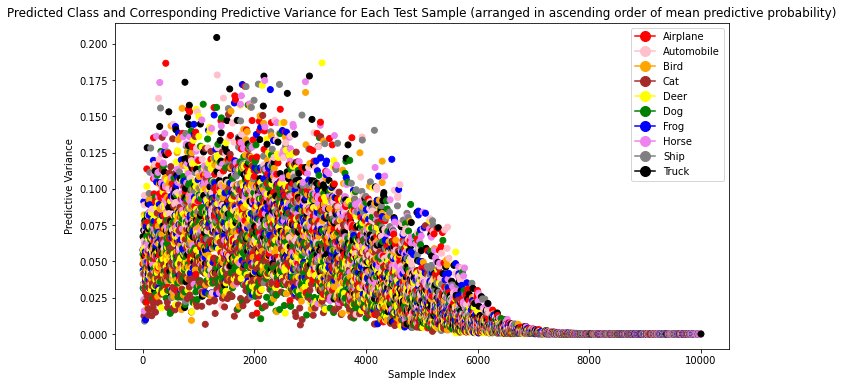

In [ ]:
plt.figure(figsize=(11,6))
plt.xlabel('Sample Index')
plt.ylabel('Predictive Variance')
plt.title('Predicted Class and Corresponding Predictive Variance for Each Test Sample (arranged in ascending order of mean predictive probability)')
plt.scatter(range(0, len(predictive_variance)),corresponding_max_vars,c=colors)
plt.legend(handles=legend_elements)

This plot may not at first glance be very suggestive, but the part of the plot with the lowest predictive variances - the "tail" on the right side of the plot - also has a "purplish" hue, which is consistent with the observation on the previous plot that the part of the curve with the highest mean predictive probabilities also has a "purplish" hue. Consistently high mean predictive probabilities also often result in consistently low predictive variances. Meanwhile, the middle and left side of the predictive-variance plot has a decent infusion of yellow, which coincides well with the observation on the previous plot that the parts of the curve corresponding to the medium and low mean predictive probabilities also have a decent infusion of yellow. Consistently medium and low mean predictive probabilities also often result in consistently medium and high predictive variances.

In [ ]:
zeros = [index for index in range(len(class_predictions)) if class_predictions[index] == 0]
ones = [index for index in range(len(class_predictions)) if class_predictions[index] == 1]
twos = [index for index in range(len(class_predictions)) if class_predictions[index] == 2]
threes = [index for index in range(len(class_predictions)) if class_predictions[index] == 3]
fours = [index for index in range(len(class_predictions)) if class_predictions[index] == 4]
fives = [index for index in range(len(class_predictions)) if class_predictions[index] == 5]
sixes = [index for index in range(len(class_predictions)) if class_predictions[index] == 6]
sevens = [index for index in range(len(class_predictions)) if class_predictions[index] == 7]
eights = [index for index in range(len(class_predictions)) if class_predictions[index] == 8]
nines = [index for index in range(len(class_predictions)) if class_predictions[index] == 9]

Obtain the average mean predictive probability for each predicted class, and plot it as a function of predicted class. This plot, with much fewer points, will help in clearly seeing which classes were, on average, predicted with higher - and lower - probabilities.

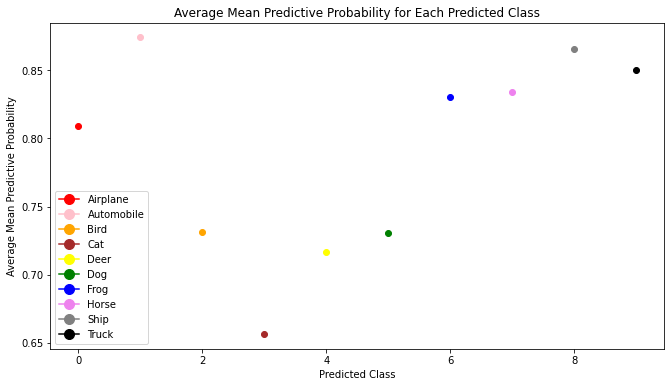

In [ ]:
plt.figure(figsize=(11,6))
plt.xlabel('Predicted Class')
plt.ylabel('Average Mean Predictive Probability')
plt.title('Average Mean Predictive Probability for Each Predicted Class')
plt.scatter(0, np.mean(sorted_max_probs[zeros]), c='red')
plt.scatter(1, np.mean(sorted_max_probs[ones]), c='pink')
plt.scatter(2, np.mean(sorted_max_probs[twos]), c='orange')
plt.scatter(3, np.mean(sorted_max_probs[threes]), c='brown')
plt.scatter(4, np.mean(sorted_max_probs[fours]), c='yellow')
plt.scatter(5, np.mean(sorted_max_probs[fives]), c='green')
plt.scatter(6, np.mean(sorted_max_probs[sixes]), c='blue')
plt.scatter(7, np.mean(sorted_max_probs[sevens]), c='violet')
plt.scatter(8, np.mean(sorted_max_probs[eights]), c='gray')
plt.scatter(9, np.mean(sorted_max_probs[nines]), c='black')
plt.legend(handles=legend_elements)

The automobile class has the highest average mean predictive probability, which means that it is the class that is predicted on average with the highest confidence. The horse class is within the top five classes that are predicted on average with the highest confidence. Thus, the previous observation that the horse and automobile classes may consistently be more confidently predicted than other classes has been verified. Other classes in the top five are ship, truck, and frog. The cat class has the lowest mean average predictive probability, which means that it is the class that is predicted on average with the least confidence. Finally, the previous observation that deer and bird may be more consistently predicted with medium or low confidence than other classes has also been verified because deer and bird are in the bottom four classes that are predicted on average with the highest confidence.

Similarly, obtain the average predictive variance for each predicted class, and plot it as a function of predicted class. This plot, also with much fewer points, will help in clearly seeing which classes were, on average, predicted with higher - and lower - variances. There may be a correspondence between the average mean predictive probability and the average predictive variance.

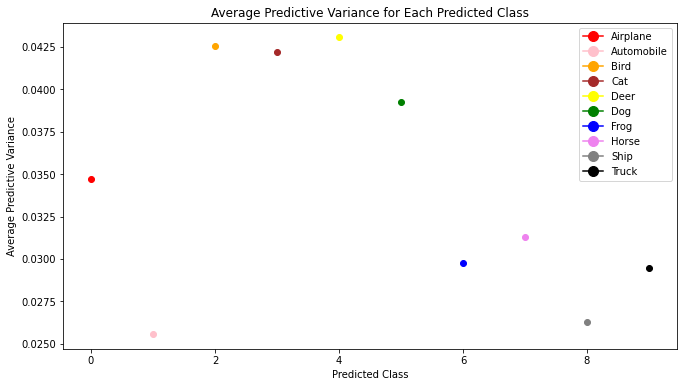

In [ ]:
plt.figure(figsize=(11,6))
plt.xlabel('Predicted Class')
plt.ylabel('Average Predictive Variance')
plt.title('Average Predictive Variance for Each Predicted Class')
plt.scatter(0, np.mean(np.array(corresponding_max_vars)[zeros]), c='red')
plt.scatter(1, np.mean(np.array(corresponding_max_vars)[ones]), c='pink')
plt.scatter(2, np.mean(np.array(corresponding_max_vars)[twos]), c='orange')
plt.scatter(3, np.mean(np.array(corresponding_max_vars)[threes]), c='brown')
plt.scatter(4, np.mean(np.array(corresponding_max_vars)[fours]), c='yellow')
plt.scatter(5, np.mean(np.array(corresponding_max_vars)[fives]), c='green')
plt.scatter(6, np.mean(np.array(corresponding_max_vars)[sixes]), c='blue')
plt.scatter(7, np.mean(np.array(corresponding_max_vars)[sevens]), c='violet')
plt.scatter(8, np.mean(np.array(corresponding_max_vars)[eights]), c='gray')
plt.scatter(9, np.mean(np.array(corresponding_max_vars)[nines]), c='black')
plt.legend(handles=legend_elements)

This plot is largely consistent with the previous plot of average mean predictive probability. The classes that have the lowest average mean predictive probabilities generally also have the highest average predictive variance. In the same vein, the classes that have the highest average mean predictive probabilities generally also have the lowest average predictive variance.